#### Denoising using combine FIR and IIR
#### Get an Inspiration from the SOF Project's Equalizers Tuning Guide: https://thesofproject.github.io/latest/algos/eq/equalizers_tuning.html

##### Wildan Aziz Hidayat, 235150301111028

Menggunakan file: original_audio.wav
Tersimpan: noisy_audio.wav
Menerapkan filter FIR dengan filtfilt...
Tersimpan: fir_filtered_audio_filtfilt.wav
Menerapkan filter IIR ke sinyal terfilter FIR dengan filtfilt...
Tersimpan: combined_fir_iir_filtered_audio_filtfilt.wav


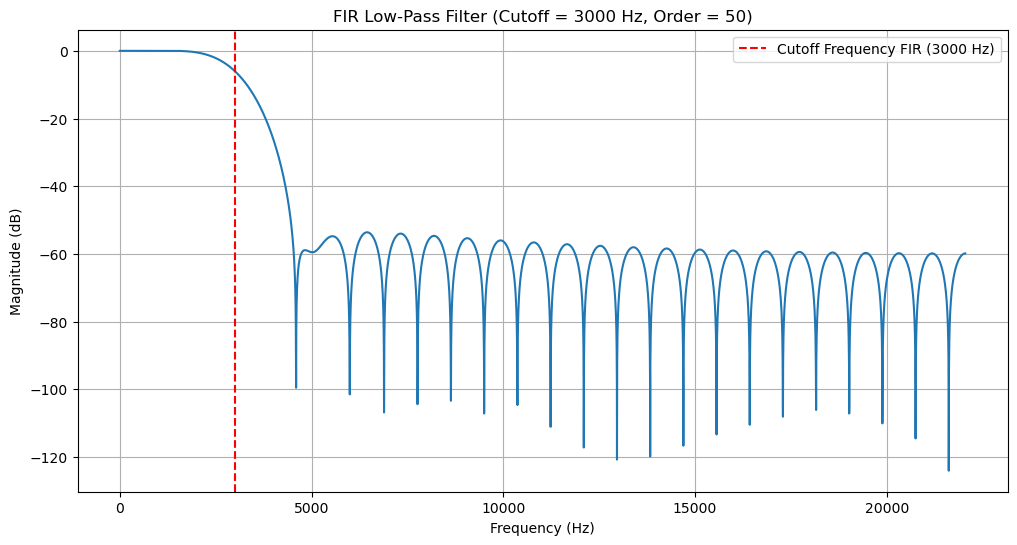

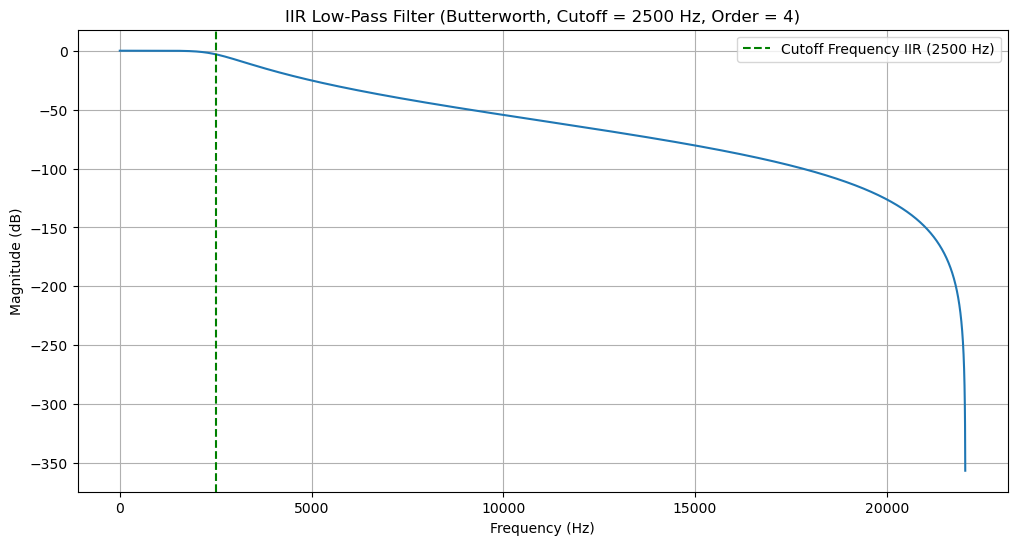

Menerapkan filter ke sinyal simulasi dengan filtfilt...


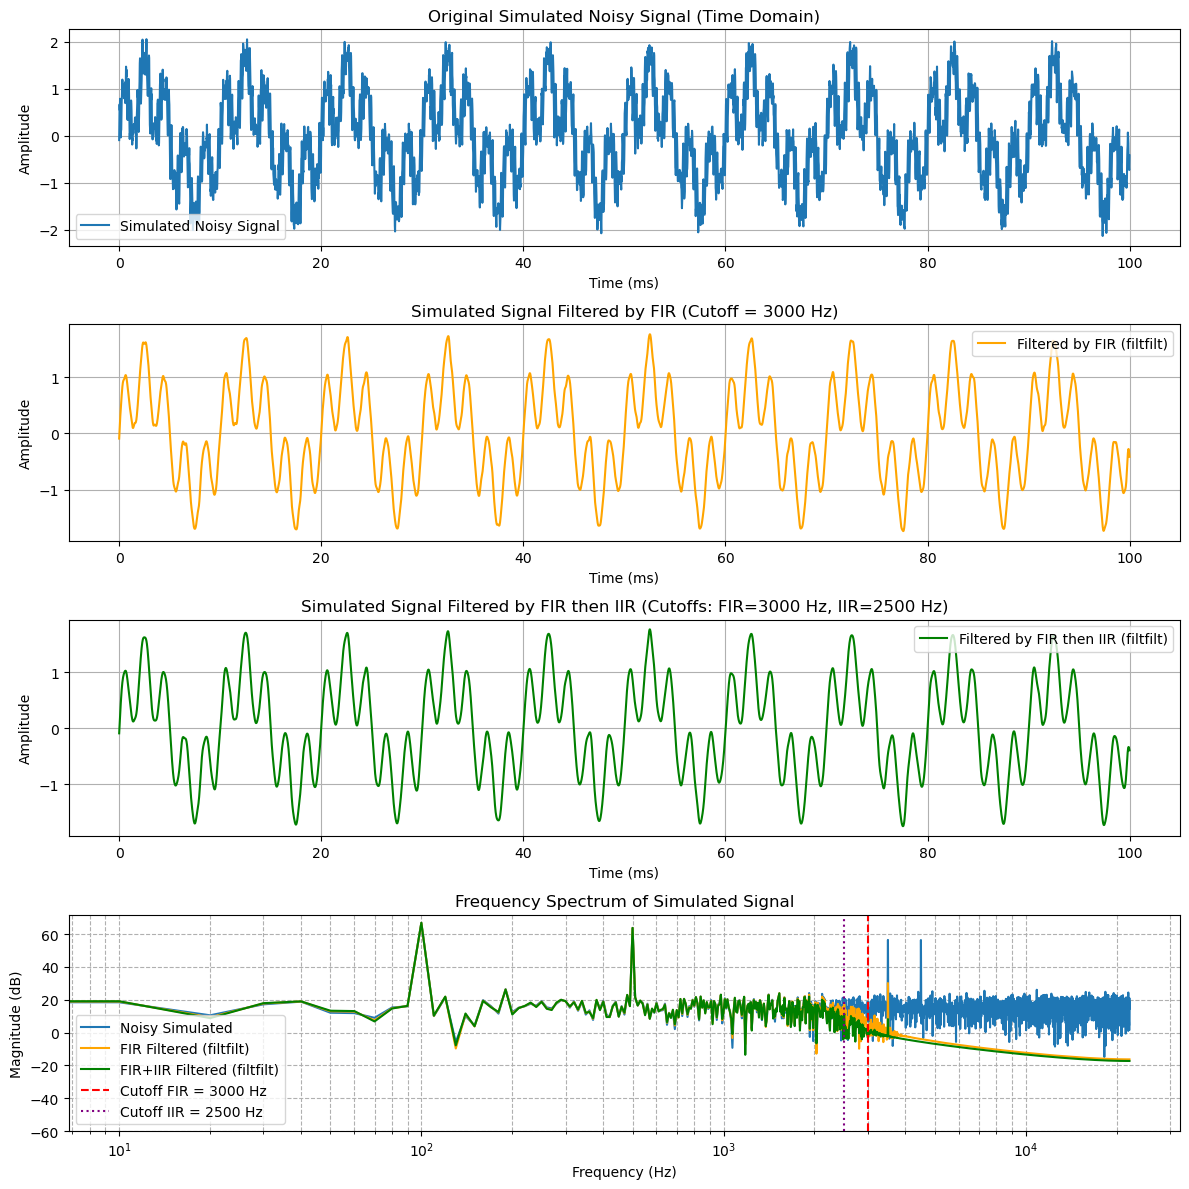

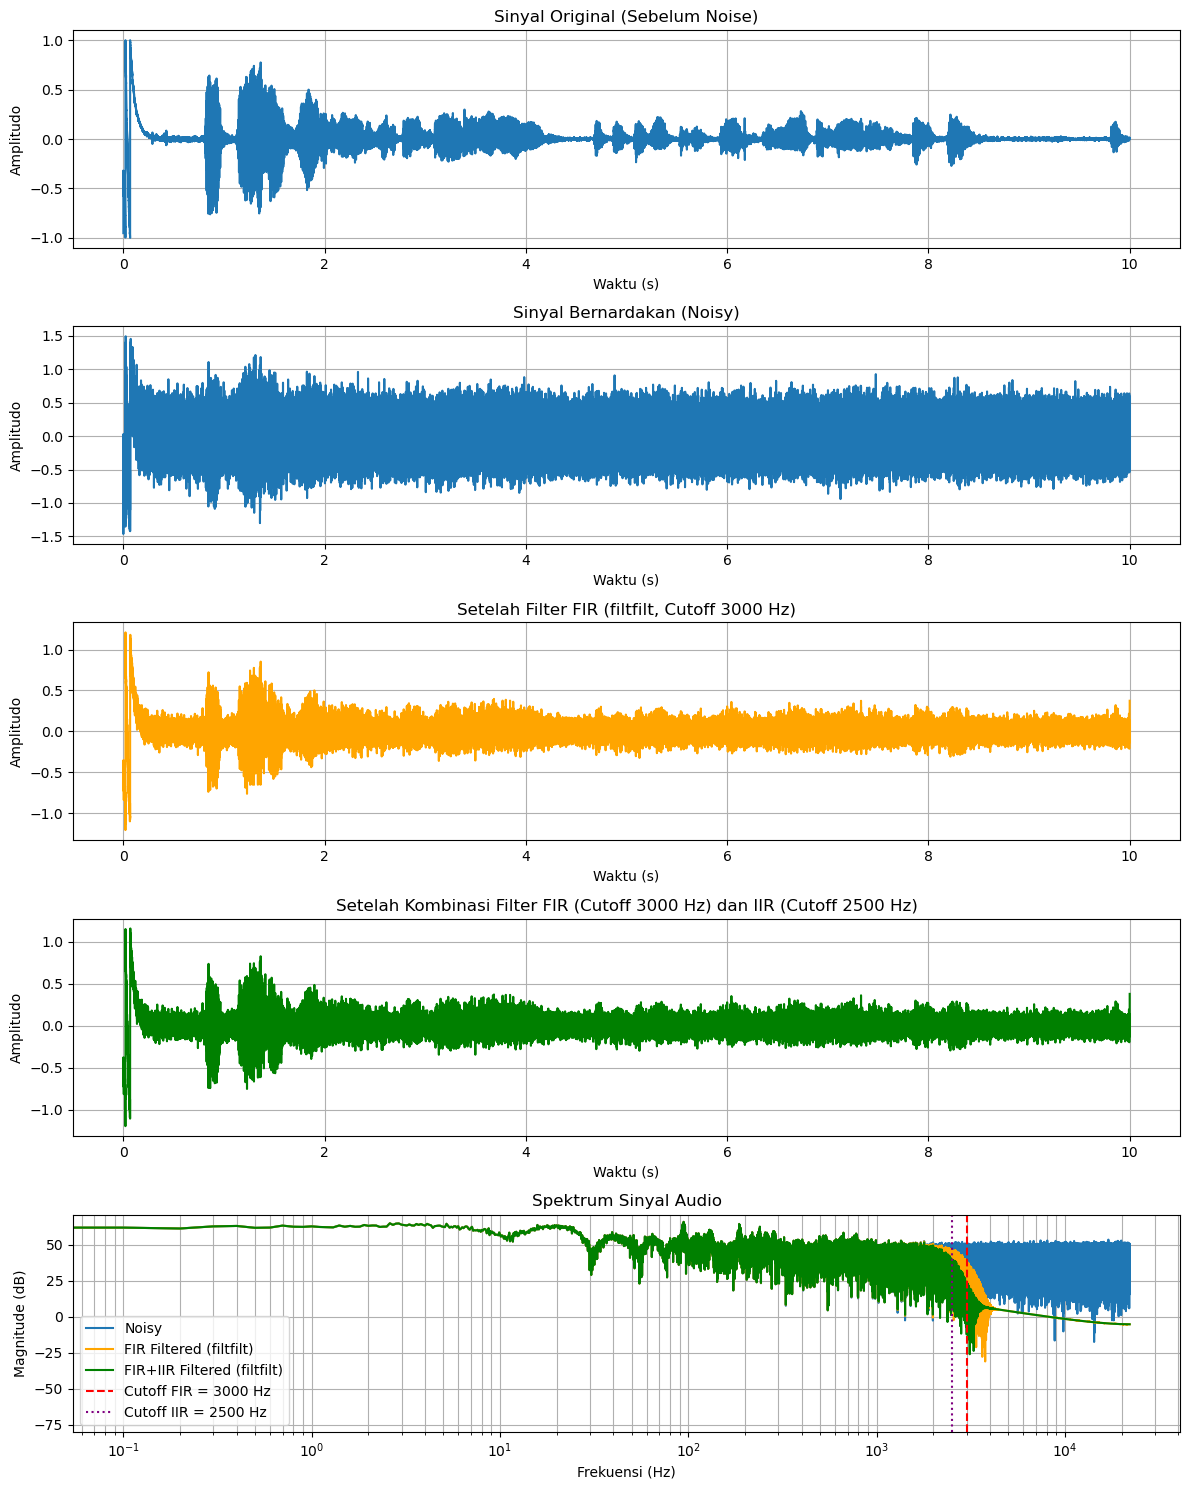

Proses selesai.


In [10]:
# Get an Inspiration from the SOF Project's Equalizers Tuning Guide:
# https://thesofproject.github.io/latest/algos/eq/equalizers_tuning.html

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, freqz, butter, filtfilt
from scipy.io import wavfile
import sounddevice as sd
import os

# — Parameters —
fs = 44100  # Sampling rate (Hz)
duration = 10  # Recording duration (s)
noise_amp = 0.2  # Contoh noise_amp yang mungkin sudah Anda naikkan

# --- MODIFIKASI FREKUENSI CUTOFF DI SINI ---
fc_fir = 3000      # Cutoff frequency untuk FIR (Hz)
fc_iir = 2500      # Cutoff frequency untuk IIR (Hz), sedikit lebih rendah
# --- AKHIR MODIFIKASI FREKUENSI CUTOFF ---

N_fir = 50  # FIR Filter order
numtaps_fir = N_fir + 1  # Total number of taps for FIR
iir_order = 4 # IIR Filter order (Anda bisa coba naikkan ini juga, misal 6)

original_file = "original_audio.wav"
noisy_file = "noisy_audio.wav"
fir_filtered_file = "fir_filtered_audio_filtfilt.wav"
combined_filtered_file = "combined_fir_iir_filtered_audio_filtfilt.wav"

# — Record if needed —
if not os.path.exists(original_file):
    print(f"Mulai merekam selama {duration}s…")
    rec = sd.rec(int(duration * fs),
                 samplerate=fs,
                 channels=1,
                 dtype='float32')
    sd.wait()
    wavfile.write(original_file,
                  fs,
                  (rec.flatten() * np.iinfo(np.int16).max).astype(np.int16))
    print(f"Tersimpan: {original_file}")
else:
    print(f"Menggunakan file: {original_file}")

# — Read & normalize —
_, data_int = wavfile.read(original_file)
data = data_int.astype(np.float32) / np.iinfo(np.int16).max

# — Add noise & save —
noisy_signal = data + noise_amp * np.random.randn(len(data))
wavfile.write(noisy_file,
              fs,
              (noisy_signal * np.iinfo(np.int16).max).astype(np.int16))
print(f"Tersimpan: {noisy_file}")

# --- MODIFIKASI BAGIAN DESAIN FILTER ---
# — FIR LPF design (Hamming) —
cutoff_norm_fir = fc_fir / (fs / 2) # Menggunakan fc_fir
fir_coeff = firwin(numtaps_fir, cutoff=cutoff_norm_fir, window='hamming')

# — Apply FIR LPF using filtfilt & save —
print("Menerapkan filter FIR dengan filtfilt...")
fir_filtered_signal = filtfilt(fir_coeff, 1.0, noisy_signal)
wavfile.write(fir_filtered_file,
              fs,
              (fir_filtered_signal * np.iinfo(np.int16).max).astype(np.int16))
print(f"Tersimpan: {fir_filtered_file}")

# — IIR LPF design (Butterworth) —
cutoff_norm_iir = fc_iir / (fs / 2) # Menggunakan fc_iir
# b_iir adalah koefisien numerator, a_iir adalah koefisien denominator
b_iir, a_iir = butter(iir_order, cutoff_norm_iir, btype='low', analog=False)
# --- AKHIR MODIFIKASI BAGIAN DESAIN FILTER ---

# — Apply IIR LPF to the FIR-filtered signal using filtfilt & save —
print("Menerapkan filter IIR ke sinyal terfilter FIR dengan filtfilt...")
combined_filtered_signal = filtfilt(b_iir, a_iir, fir_filtered_signal)
wavfile.write(combined_filtered_file,
              fs,
              (combined_filtered_signal * np.iinfo(np.int16).max).astype(np.int16))
print(f"Tersimpan: {combined_filtered_file}")

# — Plot frequency response of FIR Filter —
w_fir, h_fir = freqz(fir_coeff, worN=8000)
frequencies_fir = w_fir * fs / (2 * np.pi)
plt.figure(figsize=(12, 6))
plt.plot(frequencies_fir, 20 * np.log10(np.abs(h_fir)))
plt.title(f'FIR Low-Pass Filter (Cutoff = {fc_fir} Hz, Order = {N_fir})') # Update fc_fir
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True, which="both", ls="-")
plt.axvline(fc_fir, color='red', linestyle='--', label=f'Cutoff Frequency FIR ({fc_fir} Hz)') # Update fc_fir
plt.legend()
plt.show()

# — Plot frequency response of IIR Filter —
w_iir, h_iir = freqz(b_iir, a_iir, worN=8000)
frequencies_iir = w_iir * fs / (2 * np.pi)
plt.figure(figsize=(12, 6))
plt.plot(frequencies_iir, 20 * np.log10(np.abs(h_iir)))
plt.title(f'IIR Low-Pass Filter (Butterworth, Cutoff = {fc_iir} Hz, Order = {iir_order})') # Update fc_iir
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True, which="both", ls="-")
plt.axvline(fc_iir, color='green', linestyle='--', label=f'Cutoff Frequency IIR ({fc_iir} Hz)') # Update fc_iir
plt.legend()
plt.show()

# — Simulated time-series & filtering (using filtfilt) —
T = 0.1
t = np.arange(0, T, 1/fs)
f1 = 100
f2 = 500
# Sesuaikan frekuensi noise simulasi jika fc_fir atau fc_iir berubah signifikan
f3 = max(fc_fir, fc_iir) + 500
f4 = max(fc_fir, fc_iir) + 1500

clean_sim_signal = (np.sin(2*np.pi*f1*t) + 0.7*np.sin(2*np.pi*f2*t))
noise_sim_signal = (0.3*np.sin(2*np.pi*f3*t) + 0.3*np.sin(2*np.pi*f4*t))
x_sim = clean_sim_signal + noise_sim_signal + 0.1 * np.random.randn(len(t)) # Gunakan noise_amp yang sama atau sesuaikan

print("Menerapkan filter ke sinyal simulasi dengan filtfilt...")
y_sim_fir = filtfilt(fir_coeff, 1.0, x_sim)
y_sim_combined = filtfilt(b_iir, a_iir, y_sim_fir)

plt.figure(figsize=(12, 12))

plt.subplot(4, 1, 1)
plt.plot(t*1e3, x_sim, label='Simulated Noisy Signal')
plt.title('Original Simulated Noisy Signal (Time Domain)')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(t*1e3, y_sim_fir, label='Filtered by FIR (filtfilt)', color='orange')
plt.title(f'Simulated Signal Filtered by FIR (Cutoff = {fc_fir} Hz)') # Update fc_fir
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(t*1e3, y_sim_combined, label='Filtered by FIR then IIR (filtfilt)', color='green')
plt.title(f'Simulated Signal Filtered by FIR then IIR (Cutoffs: FIR={fc_fir} Hz, IIR={fc_iir} Hz)') # Update fc_fir, fc_iir
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.subplot(4, 1, 4)
f_axis_sim = np.fft.rfftfreq(len(t), 1/fs)
fft_x_sim = np.abs(np.fft.rfft(x_sim))
fft_y_sim_fir = np.abs(np.fft.rfft(y_sim_fir))
fft_y_sim_combined = np.abs(np.fft.rfft(y_sim_combined))
epsilon = 1e-9
plt.semilogx(f_axis_sim, 20*np.log10(fft_x_sim + epsilon), label='Noisy Simulated')
plt.semilogx(f_axis_sim, 20*np.log10(fft_y_sim_fir + epsilon), label='FIR Filtered (filtfilt)', color='orange')
plt.semilogx(f_axis_sim, 20*np.log10(fft_y_sim_combined + epsilon), label='FIR+IIR Filtered (filtfilt)', color='green')
plt.title('Frequency Spectrum of Simulated Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(which='both', linestyle='--')
plt.axvline(fc_fir, color='red', linestyle='--', label=f'Cutoff FIR = {fc_fir} Hz') # Update fc_fir
plt.axvline(fc_iir, color='purple', linestyle=':', label=f'Cutoff IIR = {fc_iir} Hz') # Tambah fc_iir
plt.ylim([-60, max(np.max(20*np.log10(fft_x_sim + epsilon)),
                    np.max(20*np.log10(fft_y_sim_fir + epsilon)),
                    np.max(20*np.log10(fft_y_sim_combined + epsilon))) + 5])
plt.legend()

plt.tight_layout()
plt.show()


# — Plot Sinyal Audio Sebenarnya (Time & Spectrum) —
t_audio = np.arange(len(data)) / fs
f_axis_audio = np.fft.rfftfreq(len(t_audio), 1/fs)

plt.figure(figsize=(12, 15))

plt.subplot(5,1,1)
plt.plot(t_audio, data)
plt.title('Sinyal Original (Sebelum Noise)')
plt.xlabel('Waktu (s)')
plt.ylabel('Amplitudo')
plt.grid(True)

plt.subplot(5,1,2)
plt.plot(t_audio, noisy_signal)
plt.title('Sinyal Bernardakan (Noisy)')
plt.xlabel('Waktu (s)')
plt.ylabel('Amplitudo')
plt.grid(True)

plt.subplot(5,1,3)
plt.plot(t_audio, fir_filtered_signal, color='orange')
plt.title(f'Setelah Filter FIR (filtfilt, Cutoff {fc_fir} Hz)') # Update fc_fir
plt.xlabel('Waktu (s)')
plt.ylabel('Amplitudo')
plt.grid(True)

plt.subplot(5,1,4)
plt.plot(t_audio, combined_filtered_signal, color='green')
plt.title(f'Setelah Kombinasi Filter FIR (Cutoff {fc_fir} Hz) dan IIR (Cutoff {fc_iir} Hz)') # Update fc_fir, fc_iir
plt.xlabel('Waktu (s)')
plt.ylabel('Amplitudo')
plt.grid(True)

plt.subplot(5,1,5)
plt.semilogx(f_axis_audio, 20*np.log10(np.abs(np.fft.rfft(noisy_signal)) + epsilon), label='Noisy')
plt.semilogx(f_axis_audio, 20*np.log10(np.abs(np.fft.rfft(fir_filtered_signal)) + epsilon), label='FIR Filtered (filtfilt)', color='orange')
plt.semilogx(f_axis_audio, 20*np.log10(np.abs(np.fft.rfft(combined_filtered_signal)) + epsilon), label='FIR+IIR Filtered (filtfilt)', color='green')
plt.axvline(fc_fir, color='red', linestyle='--', label=f'Cutoff FIR = {fc_fir} Hz') # Update fc_fir
plt.axvline(fc_iir, color='purple', linestyle=':', label=f'Cutoff IIR = {fc_iir} Hz') # Tambah fc_iir
plt.title('Spektrum Sinyal Audio')
plt.xlabel('Frekuensi (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.grid(True, which="both", ls="-")
plt.ylim([-80, max(np.max(20*np.log10(np.abs(np.fft.rfft(noisy_signal)) + epsilon)),
                    np.max(20*np.log10(np.abs(np.fft.rfft(fir_filtered_signal)) + epsilon)),
                    np.max(20*np.log10(np.abs(np.fft.rfft(combined_filtered_signal)) + epsilon))) + 5])

plt.tight_layout()
plt.show()

print("Proses selesai.")